# **ПРОГНОЗ СТОИМОСТИ АВТОМОБИЛЕЙ**
# EDA
## Задача
Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Для оценки использовать метрику MAPE

С помощью данного ноутбука мы провели обаботку и анализ данных и подготовили датасет к обучению.

Также в этом проекте мы использовали:

* Ноутбук, через который парсили https://www.kaggle.com/tatianamukhidaeva/prj5-kirill-n-tanya-m-parser
* Спарсенный датасет https://www.kaggle.com/tatianamukhidaeva/cars-df-v2
* Ноутбук, в котором провели EDA и обучение https://www.kaggle.com/tatianamukhidaeva/prj5-kirill-n-tanya-m-eda

## Библиотеки

Задача: спрогнозировать стоимость автомобилей, используя данные 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import StackingRegressor

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import time
import os

from pandas import Series
import re

import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm
from datetime import timedelta, datetime, date

import json

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# Подготовим функции для простоты дальнейшей работы:
def visualizing_number(data, column): 
    bins = 100
    if data[column].nunique() < 100:
        bins = data[column].nunique()
    
    fig, axes = plt.subplots(2,1, figsize=(26,8))
    sns.boxplot(ax=axes[0], y = data[column],data=data, orient='h')
    axes[0].set_title(column)
    data[column].hist(ax=axes[1], bins = bins)
    plt.show()
    print()
    

def get_outliers(column): 
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_out = Q1 - 1.5 * IQR
    max_out = Q3 + 1.5 * IQR
    return (column < min_out).sum() + (column > max_out).sum(), min_out, max_out

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' 
DIR_TRAIN2 = '../input/cars-df-v2/' #импортируем данные, которые были предвариельно взяты с сайта авто.ру
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

cars-df-v2  parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [8]:
train_2020 = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')
train = pd.read_csv(DIR_TRAIN2+'cars_df.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34240 entries, 0 to 34239
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34240 non-null  object
 1   brand                 34240 non-null  object
 2   car_url               34240 non-null  object
 3   color                 34240 non-null  object
 4   description           34240 non-null  object
 5   engineDisplacement    34240 non-null  object
 6   enginePower           34240 non-null  object
 7   fuelType              34240 non-null  object
 8   image                 34240 non-null  object
 9   mileage               34240 non-null  object
 10  modelDate             34240 non-null  int64 
 11  model_name            34240 non-null  object
 12  name                  34240 non-null  object
 13  numberOfDoors         34240 non-null  int64 
 14  parsing_unixtime      34240 non-null  int64 
 15  priceCurrency         34240 non-null

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Заметим, что в файле 2020 года объявлений гораздо больше, чем в датасете 2021 года. Однако спарсить большее количество не удалось. Также цены в 2021 году сильно изменились. Учтем инфляцию и объединим датасеты 2020 и 2021 года.

## Учет инфляции

С 2020 по 2021 год цены на автомобили сильно поднялись, особенно на популярные модели. Почитать об этом можно по ссылкам:
- https://mag.auto.ru/article/risepricescalltouchpres/
- https://cenamashin.ru/statistika/moskva/avg_price?seg=1

Причем цены на разные бренды менялись по-разному

In [12]:

# удалим знак валюты и пробелы в цене
train['price'] =train['price'].astype(str)
train['price'] = train['price'].apply(lambda x: x if len(x) ==1 else ''.join(x.split()[0:-1])).astype(int)

In [13]:
# инфляция по брендам


brands = test.brand.unique()
infs = []
for brand in brands:
    mean20 = train_2020[train_2020["brand"]==brand].price.mean()
    mean21 = train[train["brand"]==brand].price.mean()
    inf = (mean21-mean20)/mean20
    infs.append(inf)
    print(f'{brand} 2020: {mean20}')
    print(f'{brand} 2021: {mean21}')
    print(f'Инфляция: {round(inf * 100,2)}%')
    print()


SKODA 2020: 657326.633273703
SKODA 2021: 910444.3177229388
Инфляция: 38.51%

AUDI 2020: 1502616.5201474202
AUDI 2021: 1677113.6928999145
Инфляция: 11.61%

HONDA 2020: 595388.4040920716
HONDA 2021: 699112.622754491
Инфляция: 17.42%

VOLVO 2020: 1776484.3166828323
VOLVO 2021: 1233911.1361125063
Инфляция: -30.54%

BMW 2020: 2387441.4331296673
BMW 2021: 2466772.130835735
Инфляция: 3.32%

NISSAN 2020: 891387.644173913
NISSAN 2021: 931886.534647724
Инфляция: 4.54%

INFINITI 2020: 1564960.196911197
INFINITI 2021: 1602153.632780083
Инфляция: 2.38%

MERCEDES 2020: 3526259.7003383883
MERCEDES 2021: 3435923.9598136283
Инфляция: -2.56%

TOYOTA 2020: 1348232.2266944733
TOYOTA 2021: 1764081.6214222484
Инфляция: 30.84%

LEXUS 2020: 2025737.124282983
LEXUS 2021: 2708173.126965638
Инфляция: 33.69%

VOLKSWAGEN 2020: 999332.647869498
VOLKSWAGEN 2021: 1113360.6555655566
Инфляция: 11.41%

MITSUBISHI 2020: 994034.449859658
MITSUBISHI 2021: 874427.4276932084
Инфляция: -12.03%



Учтем инфляцию и изменим цены так, чтобы они были похожи на осень 2020 года

In [14]:
brands = test.brand.unique()
tt = train.copy()
display(tt.head(2))
for brand in brands:
    mean20 = train_2020[train_2020["brand"]==brand].price.mean()
    mean21 = train[train["brand"]==brand].price.mean()
    inf = (mean21-mean20)/mean20
    if inf>0:
        tt.loc[tt["brand"]==brand, ['price']] = tt.loc[tt["brand"]==brand, ['price']].apply(lambda x: round(x/(1+inf),0))
display(tt.head(2))

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,equipmentGroups
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,Машине нужны любящие руки понимающего человека...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,205 500 км,...,LIFTBACK MECHANICAL 1.8,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,620999,"[{'name': 'Безопасность', 'values': ['Антиблок..."
1,компактвэн,SKODA,https://auto.ru/cars/used/sale/skoda/roomster/...,серый,🔆Добрый день! Просьба приезжать в маске! \n👁Ос...,1.4 LTR,86 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,86 602 км,...,COMPACTVAN MECHANICAL 1.4,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,699000,"[{'name': 'Безопасность', 'values': ['Подушка ..."


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,equipmentGroups
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,Машине нужны любящие руки понимающего человека...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/ggLF9n453/6ee1a95w/V...,205 500 км,...,LIFTBACK MECHANICAL 1.8,механическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,448352.0,"[{'name': 'Безопасность', 'values': ['Антиблок..."
1,компактвэн,SKODA,https://auto.ru/cars/used/sale/skoda/roomster/...,серый,🔆Добрый день! Просьба приезжать в маске! \n👁Ос...,1.4 LTR,86 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,86 602 км,...,COMPACTVAN MECHANICAL 1.4,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,504667.0,"[{'name': 'Безопасность', 'values': ['Подушка ..."


In [15]:
# Цены изменились верно.
data = tt

## Data Preprocessing

### Подготовка столбцов к объединению

In [16]:
print(train.columns)
print(train_2020.columns)
print(test.columns)

Index(['bodyType', 'brand', 'car_url', 'color', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'priceCurrency', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'price', 'equipmentGroups'],
      dtype='object')
Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')
Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
   

In [17]:
# Создадим список общих переменных для теста и трейна:
s2020 = list(train_2020.columns)
s2021 = list(train.columns)
s = set(list(test.columns))
no2020 = [x for x in s if not x in s2020] #найдем стобцы, которых нет в трейне
print('Столбцы, которые есть в тесте, но их нет в трейне 2020:', no2020)
no2021 = [x for x in s if not x in s2021] #найдем стобцы, которых нет в трейне
print('Столбцы, которые есть в тесте, но их нет в трейне 2021:', no2021)
#посмотрим, какие признаки отличают два датасета, чтобы определить нужно ли дополнительно парсить данные для трейна или не стоит
#test[s3]
#model_info дублирует полезную информацию из столбца car_url, 
#super_gen - аккумулирует и дублирует много информации с разных стобцов,
#а остальные столбцы имеют много пропусков и не совсем репрезентативны


Столбцы, которые есть в тесте, но их нет в трейне 2020: ['image', 'model_info', 'sell_id', 'model_name', 'car_url', 'equipment_dict', 'super_gen', 'priceCurrency', 'complectation_dict', 'vendor', 'parsing_unixtime']
Столбцы, которые есть в тесте, но их нет в трейне 2021: ['model_info', 'equipment_dict', 'super_gen', 'complectation_dict', 'vendor', 'Владение']


**Столбцы, которых нет в трейне 2021**

'super_gen'  - аккумулирует и дублирует много информации с разных стобцов, 

'model_info' - дублирует полезную информацию из столбца car_url,

'Владение' - длительность последнего  или общего владения (не удалось спарсить, так как эти данные подгружаются AJAX), 

'vendor' - продавец, пока уберем этот столбец, 

'equipment_dict' - аналог 'equipmentGroups', 

'complectation_dict' - частично содержится в 'equipmentGroups'

In [18]:
train['equipment_dict'] = train['equipmentGroups']
train = train.drop(['equipmentGroups'], axis=1)

train.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'priceCurrency', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'price', 'equipment_dict'],
      dtype='object')

**Столбцы, которых нет в трейне 2020**

'sell_id' - создадим его, наполнив 0

'car_url' - создадим, изменив model

'priceCurrency', 'parsing_unixtime', 'complectation_dict', 'equipment_dict', 'image', 'super_gen' - можно удалить,


In [19]:
train_2020['sell_id'] = 0
train['sell_id'] = 0
train_2020['car_url'] = train_2020['model']

In [20]:
# список общих переменных
columns2021 = [x for x in s2021 if not x in no2021]
print('Общие для 2021')
print('Общее количество', len(columns2021))
print(columns2021)

columns2020 = [x for x in s2020 if not x in no2020]
print('Общие для 2020')
print('Общее количество', len(columns2020))
print(columns2020)
# columns

Общие для 2021
Общее количество 28
['bodyType', 'brand', 'car_url', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price', 'equipmentGroups']
Общие для 2020
Общее количество 26
['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower', 'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date', 'hidden', 'model']


Удалим столбцы:

Из 2021

- *не несут информации для цены* - 'image','parsing_unixtime',
- *слишком сложные в обработке* - 'description', 'equipmentGroups'
- *дублируют другие признаки* -'model_name', 
- *единственное значение* - 'priceCurrency', 'Состояние'


In [21]:
print('train - priceCurrency - ', train.priceCurrency.value_counts(), sep='\n')
print('test - priceCurrency - ', test.priceCurrency.value_counts(), sep='\n')
print()
print('train - Состояние - ', train['Состояние'].value_counts(), sep='\n')
print('test - Состояние - ', test['Состояние'].value_counts(), sep='\n')

train - priceCurrency - 
RUB    34240
Name: priceCurrency, dtype: int64
test - priceCurrency - 
RUB    34686
Name: priceCurrency, dtype: int64

train - Состояние - 
Не требует ремонта    34238
Битый / не на ходу        2
Name: Состояние, dtype: int64
test - Состояние - 
Не требует ремонта    34686
Name: Состояние, dtype: int64


In [22]:
to_del = ['image','parsing_unixtime','priceCurrency','description','model_name', 'Состояние','equipmentGroups']

In [23]:
columns = [x for x in columns2021 if not x in to_del] 
columns = ([x for x in columns if x in columns2020+['car_url', 'sell_id']] )

У тестового датасета нет цены, добавим нулевую цену

In [24]:
test['price']=0

In [25]:
df_train_2020 = train_2020[columns]
df_train = train[columns]
df_test = test[columns]

### Объединение train и test

In [26]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train_2020['sample'] = 1 # помечаем где у нас трейн
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).append(df_train_2020, sort=False).reset_index(drop=True) # объединяем
data[data['sample']==0].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(34686, 22)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158304 entries, 0 to 158303
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              158303 non-null  object 
 1   brand                 158304 non-null  object 
 2   car_url               158304 non-null  object 
 3   color                 158304 non-null  object 
 4   engineDisplacement    158303 non-null  object 
 5   enginePower           158303 non-null  object 
 6   fuelType              158304 non-null  object 
 7   mileage               158304 non-null  object 
 8   modelDate             158303 non-null  float64
 9   name                  158303 non-null  object 
 10  numberOfDoors         158303 non-null  float64
 11  productionDate        158304 non-null  int64  
 12  sell_id               158304 non-null  int64  
 13  vehicleConfiguration  158303 non-null  object 
 14  vehicleTransmission   158303 non-null  object 
 15  

У нас получилось 21 признак. Из которых 6 числовые, 15 категориальные.

In [28]:
#переименуем признаки
data.rename(columns={'productionDate': 'production_date',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'vehicle_transmission',
                     'name':'gear',
                     'Владельцы': 'owners_qty',
                     'Владение': 'ownership_time',
                     'ПТС': 'licence',
                     'Привод': 'type_of_drive',
                     'Руль': 'steering_wheel',
                     'Таможня': 'customs', 
                     'Price': 'price',
                     'bodyType': 'body_type', 
                     'engineDisplacement': 'engine_volume',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel_type',
                     'modelDate': 'model_date',
                     'numberOfDoors': 'number_of_doors',}, inplace=True)
data.columns

Index(['body_type', 'brand', 'car_url', 'color', 'engine_volume',
       'engine_power', 'fuel_type', 'mileage', 'model_date', 'gear',
       'number_of_doors', 'production_date', 'sell_id',
       'vehicle_configuration', 'vehicle_transmission', 'owners_qty',
       'licence', 'type_of_drive', 'steering_wheel', 'customs', 'price',
       'sample'],
      dtype='object')

* body_type - тип кузова,
* brand - марка автомобиля,
* car_url - url страницы объявления
* color - цвет автомобиля,
* engine_displacement - объём двигателя,
* engine_volume - мощность двигателя,
* fuel_type - тип топлива,
* mileage - пробег,
* model_date - дата релиза модели,
* name - имя, введенное пользователем
* number_of_doors - количество дверей,
* production_date - дата производства автомобиля
* vehicle_configuration - конфигурация транспортного средства (ТС),
* vehicle_transmoission - тип коробки передач,
* owners_qty - количество владельцев,
* licence - паспорт ТС,
* type_of_drive - тип привода,
* steering_wheel - сторона руля,
* customs - этап растаможки,
* price - цена автомобиля, целевой параметр,
* sample - индикатор принадлежности данных к тесту (0) и трейну (1),


In [29]:
#удалим дубликаты из датафрейма
# data[data.duplicated(keep=False)]
data = data.drop_duplicates()
data[data['sample'] ==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   body_type              34686 non-null  object 
 1   brand                  34686 non-null  object 
 2   car_url                34686 non-null  object 
 3   color                  34686 non-null  object 
 4   engine_volume          34686 non-null  object 
 5   engine_power           34686 non-null  object 
 6   fuel_type              34686 non-null  object 
 7   mileage                34686 non-null  object 
 8   model_date             34686 non-null  float64
 9   gear                   34686 non-null  object 
 10  number_of_doors        34686 non-null  float64
 11  production_date        34686 non-null  int64  
 12  sell_id                34686 non-null  int64  
 13  vehicle_configuration  34686 non-null  object 
 14  vehicle_transmission   34686 non-null  object 
 15  ow

# # ***EDA***

In [30]:
# числовые признаки
num_cols = []

# бинарные признаки
bin_cols = []

# категориальные признаки
cat_cols = []

# обработанные категориальные признаки
ready_cat_cols = []

## **CAR_URL**

In [31]:
data1 = data.copy() # сохраним данные в data1, чтобы зафиксировать изменения
data[data['sample']==0].shape

(34686, 22)

In [32]:
data.car_url

0         https://auto.ru/cars/used/sale/skoda/octavia/1...
1         https://auto.ru/cars/used/sale/skoda/octavia/1...
2         https://auto.ru/cars/used/sale/skoda/superb/11...
3         https://auto.ru/cars/used/sale/skoda/octavia/1...
4         https://auto.ru/cars/used/sale/skoda/octavia/1...
                                ...                        
158299                                               RODIUS
158300                                               RODIUS
158301                                               STAVIC
158302                                               STAVIC
158303                                               STAVIC
Name: car_url, Length: 151852, dtype: object

In [33]:
#Изменим столбец car_url на модель авто

value = data.car_url.apply(lambda x: x.lower() if len(x.split('/'))==1 else x.split('/')[7].lower())
idx = data.columns.get_loc('brand') 
data.insert(loc=idx+1, column='model_of_car', value=value )
data = data.drop('car_url',1)
data[data['sample'] ==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   body_type              34686 non-null  object 
 1   brand                  34686 non-null  object 
 2   model_of_car           34686 non-null  object 
 3   color                  34686 non-null  object 
 4   engine_volume          34686 non-null  object 
 5   engine_power           34686 non-null  object 
 6   fuel_type              34686 non-null  object 
 7   mileage                34686 non-null  object 
 8   model_date             34686 non-null  float64
 9   gear                   34686 non-null  object 
 10  number_of_doors        34686 non-null  float64
 11  production_date        34686 non-null  int64  
 12  sell_id                34686 non-null  int64  
 13  vehicle_configuration  34686 non-null  object 
 14  vehicle_transmission   34686 non-null  object 
 15  ow

In [34]:
data['model_of_car'].value_counts

<bound method IndexOpsMixin.value_counts of 0         octavia
1         octavia
2          superb
3         octavia
4         octavia
           ...   
158299     rodius
158300     rodius
158301     stavic
158302     stavic
158303     stavic
Name: model_of_car, Length: 151852, dtype: object>

In [35]:
cat_cols.append('model_of_car')


# **bodyType**

In [36]:
data['body_type'].unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон', 'универсал 3 дв.', 'Седан',
       'Универсал 5 дв.', 'Хэтчбек 5 дв. Sportback', 'Хэтчбек 3 дв.',
       'Хэтчбек 5 дв.', 'Кабриолет', 'Купе', 'Лифтбек Sportback',
       'Лифтбек', 'Седан Long', 'Внедорожник 5 дв.', 'Кабриолет Roadster',
       'Седан 2 дв.', 'Седан Gran Coupe', 'Компактвэн',
       'Компактвэн Gran Tourer', 'Лифтбек Gran Turismo',
       'Хэтчбек 3 дв. Compact', 'Лифтбек Gran Coupe', 'Купе-хардтоп',
       'Родстер Roadster', 'Родстер', 'Внедорожник 5 дв. ESV', 'Минивэн',
       'Пикап Двойная кабина', 'Внедорожник 3 дв.',
       'Пикап Одинарная кабин

In [37]:
#переделаем названия
data['body_type'] = data['body_type'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['body_type'] = data['body_type'].apply(lambda x: x.split(' ')[0].lower())

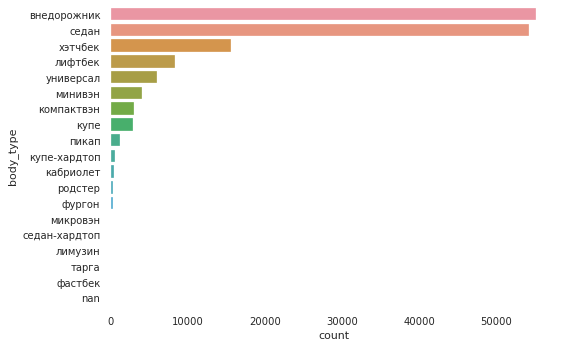

In [38]:
sns.countplot(y = data['body_type'], data = data, order = data['body_type'].value_counts().index)
# sns.countplot?

Самый популярный кузов внедорожник, на втором месте седан

посмотрим на пропуски,если они есть,заполним их кузов типа "внедорожник"

In [39]:
data.at[93550,'body_type'] = None

In [40]:
data['body_type'].isna().sum()

1

In [41]:
data['body_type'] = data['body_type'].fillna(data['body_type'].mode())

In [42]:
cat_cols.append('body_type')

In [43]:
data[data['sample']==0].shape

(34686, 22)

# **brand**

In [44]:
data['brand'].unique() 

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG'], dtype=object)

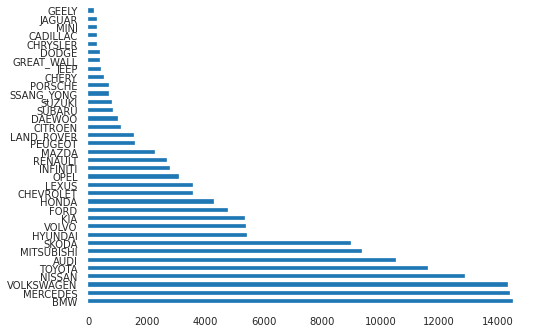

In [45]:
data['brand'].value_counts().plot.barh()

Наиболее популярные бренды-, БМВ, Mercedes

In [46]:
data['brand'].isnull().sum()

0

In [47]:
cat_cols.append('brand')

# **color**

In [48]:
data['color'].unique() 

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       '040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB'], dtype=object)

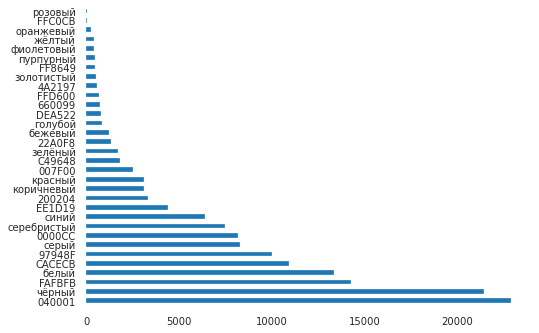

In [49]:
data['color'].value_counts().plot.barh()

Самый популярные цвета среди автомобилей - чёрный и белый

In [50]:
#переименуем признак
color_dict = {'040001':'black', 
              'FAFBFB':'white',
              'CACECB':'silver',
              '97948F':'grey',
              'чёрный':'black',
              '0000CC':'blue',
              'белый':'white',
              '200204':'brown',
              'EE1D19':'red',
              'серебристый':'silver',
              'серый':'grey',
              'синий':'blue',
              '007F00':'green',
              'C49648':'beige',
              'красный':'red', 
              'коричневый':'brown',
              '22A0F8':'light_blue',
              'зелёный':'green',
              '660099':'purple',
              'DEA522':'gold',
              '4A2197':'violet',
              'бежевый':'beige',
              'FFD600':'yellow',
              'голубой':'light_blue',
              'FF8649':'orange',
              'золотистый':'gold',
              'пурпурный':'purple',
              'фиолетовый':'violet',
              'жёлтый':'yellow',
              'оранжевый':'orange',
              'FFC0CB':'pink',
              'розовый':'pink'
             }

In [51]:
data['color'] = data['color'].map(color_dict)

Разделим цвета по популярности. Самые популярные: 1, менее популярные: 2,еще менее популярные: 3, не популярные: 4

In [52]:
  
pop_color_dict = {
    'white': 1,
    'black': 1,
    'blue': 2,
    'silver': 2,
    'grey': 2,
    'brown': 3,
    'red': 3, 
    'green': 3,
    'beige': 3,
    'light_blue': 3,
    'purple': 4,
    'yellow': 4, 
    'orange': 4,
    'violet': 4, 
    'gold': 4, 
    'pink': 4
}
data['color'] = data['color'].map(pop_color_dict)

In [53]:
ready_cat_cols.append('color')

In [54]:
data['color'].isnull().sum()


0

In [55]:
data['color'].fillna(1, inplace=True)

In [56]:
data[data['sample']==0].shape

(34686, 22)

# **fuelType**

In [57]:
data['fuel_type'].unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ', 'универсал'],
      dtype=object)

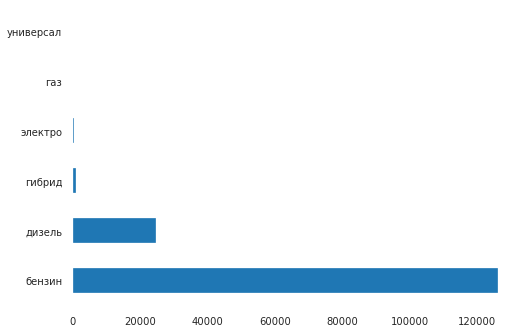

In [58]:
data['fuel_type'].value_counts().plot.barh()

Наиболее популярные машины на бензине, наименее - на газу

In [59]:
# дадим латинские названия
d = {
    'бензин': 'petrol', 
    'дизель': 'diesel', 
    'гибрид': 'hybrid', 
    'электро': 'electro', 
    'газ': 'gas'
}
data['fuel_type'] = data['fuel_type'].map(d)

In [60]:
cat_cols.append('fuel_type')

# **model_date,production_date**

In [61]:
data2 = data.copy() # Зафиксируем датасет перед изменениями

In [62]:
np.sort(data['model_date'].unique())

array([1904., 1908., 1927., 1932., 1934., 1935., 1936., 1937., 1938.,
       1948., 1949., 1950., 1951., 1953., 1954., 1955., 1956., 1957.,
       1958., 1959., 1960., 1961., 1963., 1964., 1965., 1966., 1967.,
       1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976.,
       1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984., 1985.,
       1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994.,
       1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003.,
       2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012.,
       2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021.,
         nan])

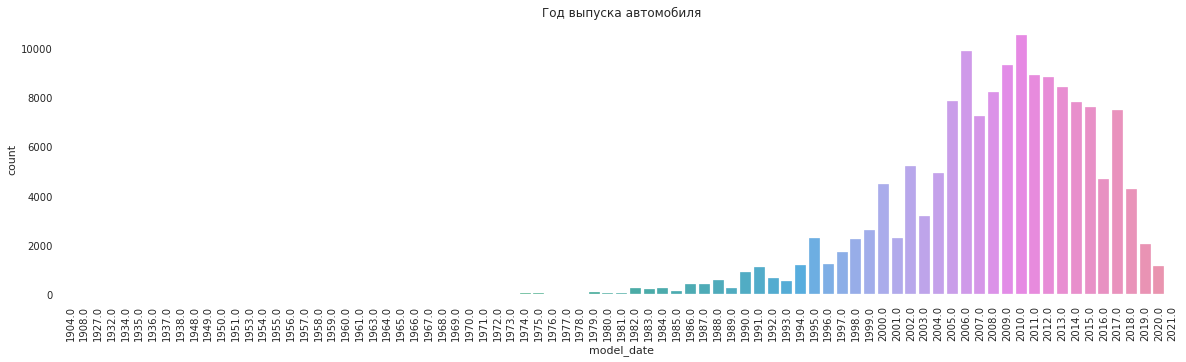

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.title('Год выпуска автомобиля')
plt.xticks(rotation=90)
sns.countplot(x='model_date', data=data, orient='v')

In [64]:
data['model_date'][data['model_date']< 1980].value_counts(dropna=False).sort_index(ascending=False)

1979.0    87
1978.0    28
1977.0    22
1976.0    19
1975.0    71
1974.0    35
1973.0     6
1972.0    18
1971.0    13
1970.0     4
1969.0     2
1968.0    10
1967.0     1
1966.0     4
1965.0     6
1964.0     2
1963.0     6
1961.0     2
1960.0     5
1959.0    12
1958.0    11
1957.0     4
1956.0     3
1955.0    11
1954.0     1
1953.0     1
1951.0     9
1950.0     1
1949.0     7
1948.0     1
1938.0    20
1937.0    11
1936.0    10
1935.0     1
1934.0     2
1932.0     2
1927.0     3
1908.0     2
1904.0     2
Name: model_date, dtype: int64

Автомобилей, произведенных ранее 1980 года очень мало. Однако должны ли мы уметь предсказывать цену на них? Возможно должны. Но:
- во-первых: данных не достаточно,
- во-вторых: даже если модель будет плохо предсказывать цены на столь старые автомобили, для основной массы результат предсказания не изменится, или даже станет лучше.

Вывод: примем эти автомобили за выбросы

In [65]:
# примем  автомобили старше 1980 г. за выбросы
data = data[~((data.model_date < 1980)&(data.sample==1))]

In [66]:
data[data['sample']==0].shape

(34686, 22)

In [67]:
data['model_date'].isnull().sum()

1

In [68]:
data = data.dropna(subset=['model_date'])

In [69]:
data['production_date'].isnull().sum()

0

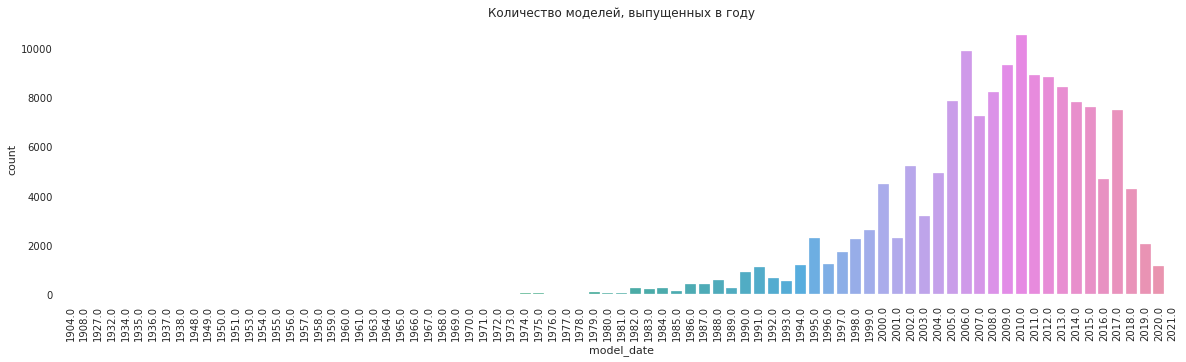

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.title('Количество моделей, выпущенных в году')
plt.xticks(rotation=90)
sns.countplot(x='model_date', data=data, orient='v')

In [71]:
#введем новые признаки возраст модели и возраст машины
from datetime import date

today = date.today()
d1 = int(today.strftime("%Y"))

data['model_date'] = data['model_date'].astype('int')
idx = data.columns.get_loc('model_date') 
data.insert(loc=idx+1, column='model_d', value=d1 - data['model_date'] )
data.insert(loc=idx+1, column='production_d', value=d1 - data['production_date'] )


In [72]:
num_cols.append('model_date')

In [73]:
num_cols.append('production_date')

In [74]:
num_cols.append('model_d')

In [75]:
num_cols.append('production_d')

In [76]:
data[data['sample']==0].shape

(34686, 24)

# **Gear**

In [77]:
data3 = data.copy() # Зафиксируем датасет перед изменениями
# data = data3.copy()

In [78]:
data['gear'].unique()

array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ..., '2.3 AT (140 л.с.)',
       '2.9d AT (132 л.с.) 4WD', '2.7d AT (165 л.с.) 4WD'], dtype=object)

In [79]:
#из признака выберем только тип трансмиссии, т. к. остальные данные у нас есть
data['gear'] = data['gear'].astype(str)
idx = data.columns.get_loc('color') 
data.insert(loc=idx+1, column='transmis', value= data['gear'].str.extract('([A][T]|[M][T]|[A][M][T]|[C][V][T])',
                                                expand=False).str.strip())

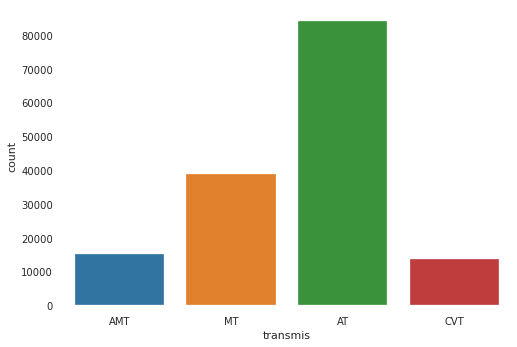

In [80]:
sns.countplot(x = data['transmis'], data = data)

Очевидно, что наиболее популряной коробкой является AT

In [81]:
data['transmis'].isnull().sum()

0

In [82]:
data['transmis']=data['transmis'].fillna('AT')

In [83]:
cat_cols.append('transmis')

In [84]:
data = data.drop('gear', 1)

# **number_of_doors**

In [85]:
data4 = data.copy() # Зафиксируем датасет перед изменениями

In [86]:
data['number_of_doors'].unique()

array([5., 4., 2., 3., 0.])

In [87]:
mode = round(data['number_of_doors'].mean(),0)
mode

4.0

In [88]:
data['number_of_doors']=data['number_of_doors'].fillna(mode)

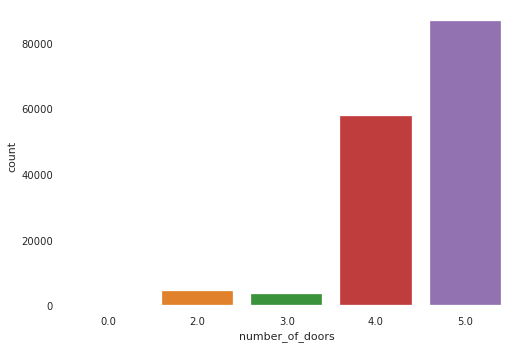

In [89]:
sns.countplot(x = data['number_of_doors'], data = data)

Наибольшее количество автомобилей имеет 5 дверей

In [90]:
num_cols.append('number_of_doors')

In [91]:
data[data['sample']==0].shape

(34686, 24)

# **vehicle_configuration**

In [92]:
data5 = data.copy() # Зафиксируем датасет перед изменениями

In [93]:
data['vehicle_configuration'].value_counts()

SEDAN MECHANICAL 1.6               6499
ALLROAD_5_DOORS AUTOMATIC 2.0      5849
ALLROAD_5_DOORS AUTOMATIC 3.0      5467
SEDAN AUTOMATIC 1.6                5216
SEDAN AUTOMATIC 2.0                5173
                                   ... 
HATCHBACK_3_DOORS MECHANICAL GT       1
WAGON_5_DOORS ROBOT 4.0               1
MINIVAN AUTOMATIC 7.3d                1
PICKUP_TWO MECHANICAL G5              1
SEDAN MECHANICAL 1.0                  1
Name: vehicle_configuration, Length: 2088, dtype: int64

Получим данные о типе коробки передач

In [94]:
data['vehicle_configuration'] = data['vehicle_configuration'].astype(
                str).apply(lambda x: x if len(x) == 1 else x.split())

In [95]:
data['vehicle_configuration'] = data['vehicle_configuration'].apply(
    lambda x: x[0].lower() if len(x) == 1 else x[1].lower())

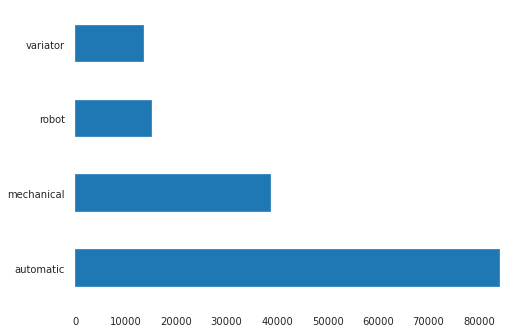

In [96]:
data['vehicle_configuration'].value_counts().plot.barh()

Больше всего машин с автоматической коробкой передач

In [97]:
cat_cols.append('vehicle_configuration')

# **engine_volume**

In [98]:
data6 = data.copy() # Зафиксируем датасет перед изменениями
# data = data6.copy()

In [99]:
data['engine_volume'].value_counts(dropna=False).head(50)

1.6        16377
2.0 LTR    15700
2.0        11490
1.6 LTR     9885
3.0 LTR     7733
1.8 LTR     5913
1.4         5295
1.8         5065
2.5 LTR     4825
2.4 LTR     3597
1.4 LTR     3581
3.5 LTR     3187
2.4         3046
2.5         2486
1.5         2104
2.0d        1983
1.5 LTR     1435
350         1339
3.0d        1334
200         1217
2.5d        1215
3.0         1156
3.5         1093
1.2 LTR      962
2.3          877
1.2          837
1.3 LTR      800
4.5 LTR      779
4.4 LTR      776
2.8 LTR      763
1.7          703
4.7 LTR      690
4.0 LTR      681
1.3          671
5.5 LTR      650
2.2d         632
3.2 LTR      607
2.1 LTR      572
500          564
300          537
250          515
320i         467
3.7 LTR      451
180          444
30d          440
2.2 LTR      429
3.6          421
2.7 LTR      411
4.2 LTR      385
ТагАЗ        379
Name: engine_volume, dtype: int64

In [100]:
data['engine_volume'] = data['engine_volume'].astype(str)

Получим объем двигателя

In [101]:
data['engine_volume'] = data['engine_volume'].str.extract('(\d.\d)',expand=False).str.strip()

In [102]:
data['engine_volume']=data['engine_volume'].astype(float)

In [103]:
data['engine_volume'] = data['engine_volume'].apply(lambda x: round(x/100,1) if (x>10) else round(x,1))

In [104]:
mean = round(data['engine_volume'].mean(),1)
mean

2.3

In [105]:
data[data['sample']==0]['engine_volume'].isnull().sum()

55

In [106]:
data['engine_volume'].fillna(mean, inplace=True)

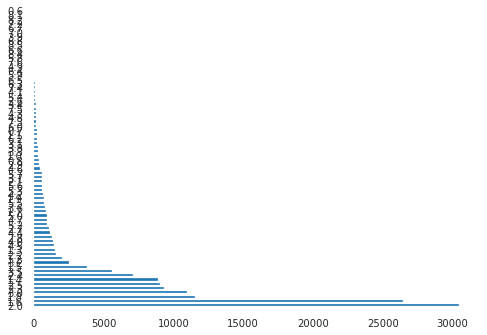

In [107]:
data['engine_volume'].value_counts().plot.barh()

In [108]:
num_cols.append('engine_volume')

In [109]:
data[data['sample']==0].shape

(34686, 24)

# **engine_power**

In [110]:
data7 = data.copy() # Зафиксируем датасет перед изменениями

In [111]:
data['engine_power']

0         105 N12
1         110 N12
2         152 N12
3         110 N12
4         152 N12
           ...   
158299        163
158300        163
158301        149
158302        149
158303        149
Name: engine_power, Length: 151851, dtype: object

In [112]:
data['engine_power'] = data['engine_power'].astype(str).apply(lambda x: x.split()[0])
data['engine_power'] = data['engine_power'].astype(float)

In [113]:
data['engine_power'].value_counts()

150.0    10317
249.0     6909
140.0     4704
110.0     4255
105.0     4097
         ...  
492.0        1
700.0        1
336.0        1
489.0        1
570.0        1
Name: engine_power, Length: 409, dtype: int64

In [114]:
data['engine_power'].value_counts().sort_index()

11.0     1
17.0     1
19.0     1
20.0     2
30.0     2
        ..
700.0    1
702.0    1
717.0    3
761.0    1
800.0    1
Name: engine_power, Length: 409, dtype: int64

In [115]:
# Разобьём признак на категории
def engine_power(x):
    if x < 100: x = 1
    elif 99 < x < 150: x = 2
    elif 149 < x < 200: x = 3
    elif 199 < x < 250: x = 4
    elif 249 < x < 300: x = 5
    elif 299 < x < 350: x = 6
    elif 349 < x < 400: x = 7
    elif 399 < x < 450: x = 8
    elif 449 < x < 500: x = 9
    elif 499 < x < 550: x = 10
    elif 549 < x < 600: x = 11
    else: x = 12
    return x  

In [116]:
data['engine_power'] = data['engine_power'].map(engine_power)

Text(0.5, 1.0, 'Мощность двигателя в л.с.')

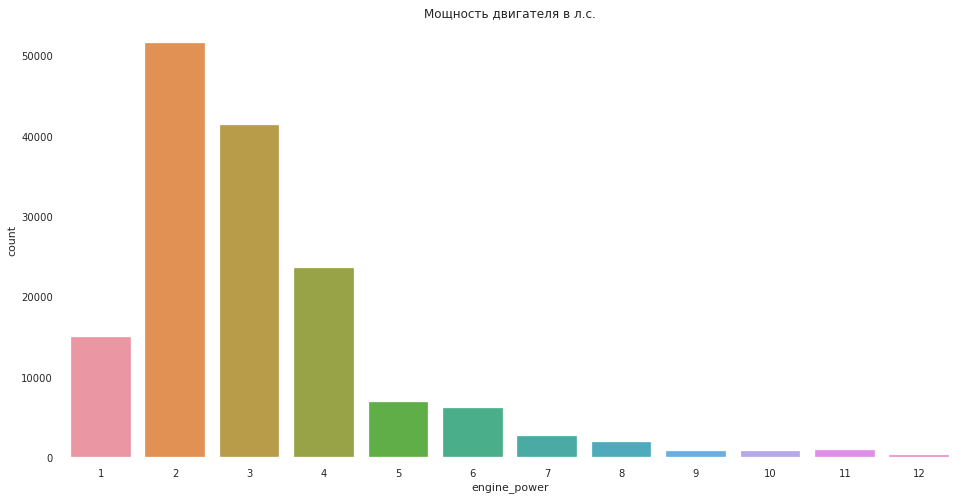

In [117]:
plt.figure(figsize=(16,8))
sns.countplot(x = data['engine_power'], data = data) 
plt.title('Мощность двигателя в л.с.')

In [118]:
data['engine_power'].isnull().sum()

0

In [119]:
num_cols.append('engine_power')

In [120]:
data[data['sample']==0].shape

(34686, 24)

# **mileage**

In [121]:
data8 = data.copy() # Зафиксируем датасет перед изменениями
# data = data8.copy()

In [122]:
data['mileage']

0          74000
1          60563
2          88000
3          95000
4          58536
           ...  
158299    260000
158300    300000
158301    126000
158302     84000
158303    144000
Name: mileage, Length: 151851, dtype: object

In [123]:
data['mileage'] = data['mileage'].astype(str).apply(lambda x: x.replace('\xa0',''))
data['mileage'] = data['mileage'].astype(str).apply(lambda x: x.replace('км',''))
data['mileage'] = data['mileage'].apply(lambda x: int(x.replace(' ','')))
data['mileage']

0          74000
1          60563
2          88000
3          95000
4          58536
           ...  
158299    260000
158300    300000
158301    126000
158302     84000
158303    144000
Name: mileage, Length: 151851, dtype: int64

In [124]:
data['mileage'].isna().sum()

0

In [125]:
num_cols.append('mileage')

# **mileage_per_year**

In [126]:
#Добавим новый признак - годовой пробег 
import math
value= round(data['mileage'].astype(int)
                                                       /(data['model_d'].apply(lambda x: x if x>0 else x+1)),-2)
idx = data.columns.get_loc('licence') 
data.insert(loc=idx+1, column='mileage_per_year', value= value)
data['mileage_per_year'] = data['mileage_per_year'].apply(lambda x: x if x != math.inf else 0 )

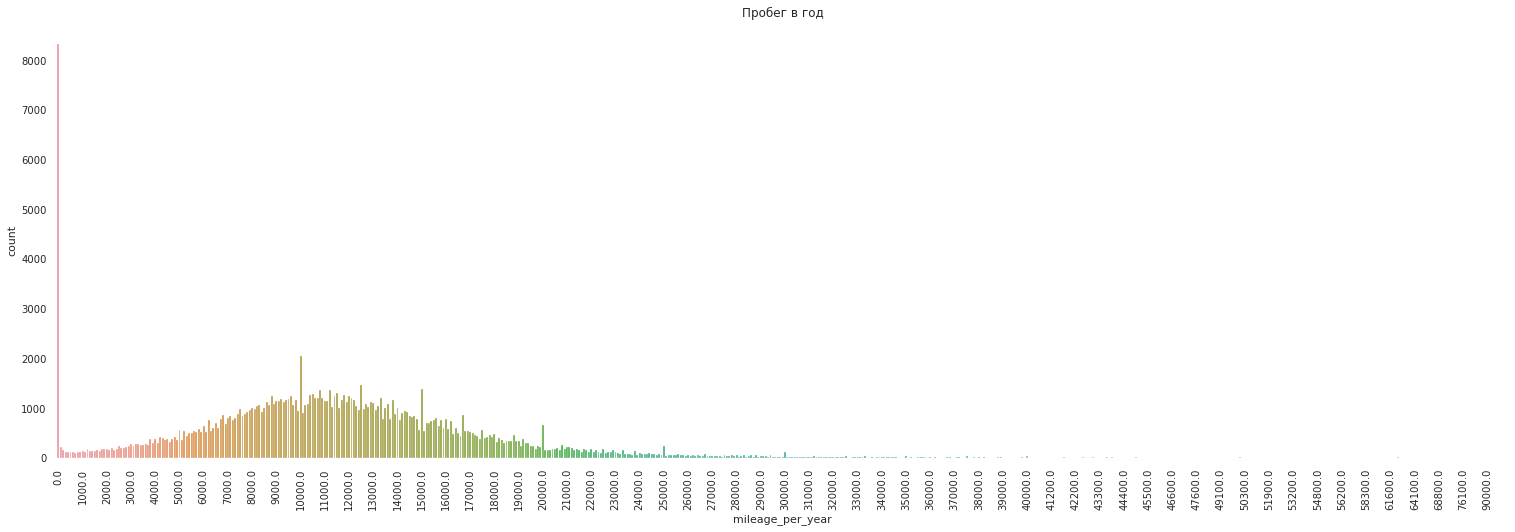

In [127]:
plt.figure(figsize=(26,8))
plt.title('Пробег в год')
plt.xticks(rotation=90)

plot_ = sns.countplot(x = data['mileage_per_year'], data = data) 
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [128]:
num_cols.append('mileage_per_year')

# **type_of_drive**

In [129]:
data9 = data.copy() # Зафиксируем датасет перед изменениями
# data = data9.copy()

In [130]:
data['type_of_drive'].unique()

array(['передний', 'полный', 'задний'], dtype=object)

In [131]:
data['type_of_drive'].value_counts(dropna=False)

передний    75614
полный      62556
задний      13681
Name: type_of_drive, dtype: int64

In [132]:
# дадим латинские названия
d = {
    'передний': 'front', 
    'полный': 'full', 
    'задний': 'back'
}
data['type_of_drive'] = data['type_of_drive'].map(d)

In [133]:
data['type_of_drive']=data['type_of_drive'].fillna('front')

Text(0.5, 1.0, 'Тип привода')

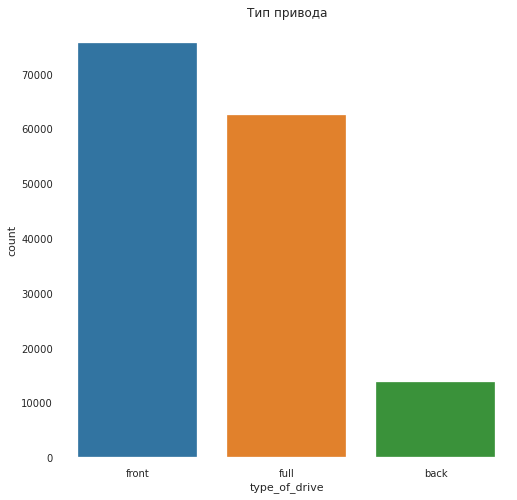

In [134]:
plt.figure(figsize=(8,8))
sns.countplot(x = data['type_of_drive'], data = data)
plt.title('Тип привода')

Наибольшее ко-во машин имеет передний привод

In [135]:
cat_cols.append('type_of_drive')

# **steering_wheel**

In [136]:
data['steering_wheel'].value_counts(dropna=False)

LEFT      81142
Левый     66250
Правый     2676
RIGHT      1783
Name: steering_wheel, dtype: int64

In [137]:
steering_wheel_dict = {'LEFT':'left', 
                       'Левый':'left',
                       'RIGHT':'right', 
                       'Правый':'right',
                        }
data['steering_wheel'] = data['steering_wheel'].map(steering_wheel_dict)

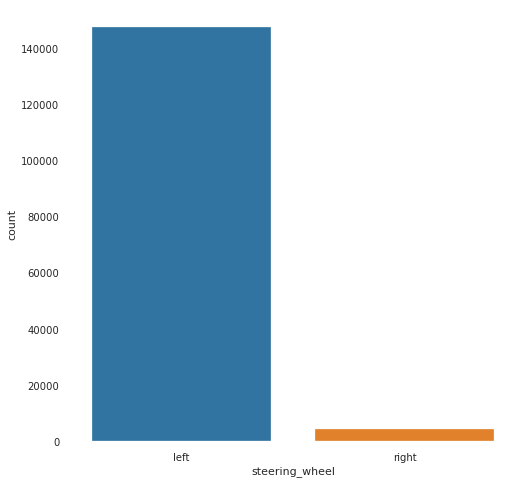

In [138]:
plt.figure(figsize=(8,8))
sns.countplot(x = data['steering_wheel'], data = data) 

Наибольшее количество машин леворульные

In [139]:
data['steering_wheel'].isnull().sum()

0

In [140]:
bin_cols.append('steering_wheel')

In [141]:
data[data['sample']==0].shape

(34686, 25)

# **owners_qty**

In [142]:
data11 = data.copy() # Зафиксируем датасет перед изменениями
# data = data11.copy()

In [143]:
data['owners_qty'].value_counts(dropna=False)
# data['owners_qty'].unique()

3.0            36002
3 или более    30275
2.0            20860
1 владелец     20524
1.0            18366
2 владельца    18127
NaN             7697
Name: owners_qty, dtype: int64

In [144]:
data['owners_qty'] = data['owners_qty'].astype(
                str).apply(lambda x: x if len(x) == 1 else x.split())
data['owners_qty']

0         [3, или, более]
1           [1, владелец]
2           [1, владелец]
3           [1, владелец]
4           [1, владелец]
               ...       
158299              [3.0]
158300              [3.0]
158301              [1.0]
158302              [3.0]
158303              [2.0]
Name: owners_qty, Length: 151851, dtype: object

In [145]:
data['owners_qty']= data['owners_qty'].apply(
    lambda x: x[0].lower() if len(x) == 1 else x[0].lower())

In [146]:
data['owners_qty']=data['owners_qty'].astype(float)

In [147]:
data['owners_qty'].isnull().sum()

7697

In [148]:
mode = round(data['owners_qty'].mode(),0)
mode

0    3.0
dtype: float64

In [149]:
data['owners_qty'].fillna(3, inplace=True)

In [150]:
ready_cat_cols.append('owners_qty')


# **licence**

In [151]:
data12 = data.copy() # Зафиксируем датасет перед изменениями
# data = data12.copy()

In [152]:
data['licence'].unique()

array(['Оригинал', 'Дубликат', nan, 'ORIGINAL', 'DUPLICATE'], dtype=object)

In [153]:
licence_dict={'Оригинал': 1,
             'Дубликат': 0,
             'ORIGINAL':1,
             'DUPLICATE':0}
data['licence'] = data['licence'].map(licence_dict)

In [154]:
data['licence'].value_counts( dropna=False)

1.0    131855
0.0     19657
NaN       339
Name: licence, dtype: int64

Если лицензия не указана, то не будем ставить, что она есть, возможно машина без документов. Установим значение 2 - отличается от остальных

In [155]:
data['licence'] = data['licence'].fillna(2)

In [156]:
ready_cat_cols.append('licence')

# **customs**

In [157]:
data['customs'].value_counts()

True             82925
Растаможен       68925
Не растаможен        1
Name: customs, dtype: int64

всего один нерастаможенный автомобиль. Нет смысла держать этот признак в датасете

In [158]:
data = data.drop('customs', 1)

## **vehicle_transmission**

In [159]:
data['vehicle_transmission'].value_counts()

AUTOMATIC           45713
автоматическая      38498
MECHANICAL          24909
механическая        13848
роботизированная     8295
вариатор             8285
ROBOT                6937
VARIATOR             5366
Name: vehicle_transmission, dtype: int64

Такой признак уже был

In [160]:
data = data.drop('vehicle_transmission',1 )

## Price

Уже делали обработку при учете инфляции для train 2021

In [161]:
data['price']

0               0.0
1               0.0
2               0.0
3               0.0
4               0.0
            ...    
158299     450000.0
158300     485000.0
158301    1090000.0
158302    1180000.0
158303    1075000.0
Name: price, Length: 151851, dtype: float64

In [162]:
data['price'][(data['sample']==1)&(data['price'].isna())]

68947    NaN
69238    NaN
69275    NaN
69580    NaN
69621    NaN
          ..
157347   NaN
157508   NaN
157593   NaN
157916   NaN
158202   NaN
Name: price, Length: 410, dtype: float64

Так как это целевая переменная, удалим пустые значения

In [163]:
data.dropna(subset=['price'], inplace=True)

In [164]:
# Посмотрим, есть ли  дубликаты:
print('Количество дубликатов:',len(data) - len(data.drop_duplicates()))

Количество дубликатов: 969


In [165]:
# data[data.duplicated(keep=False)]
data = data.drop_duplicates()
data.isna().sum()

body_type                0
brand                    0
model_of_car             0
color                    0
transmis                 0
engine_volume            0
engine_power             0
fuel_type                0
mileage                  0
model_date               0
production_d             0
model_d                  0
number_of_doors          0
production_date          0
sell_id                  0
vehicle_configuration    0
owners_qty               0
licence                  0
mileage_per_year         0
type_of_drive            0
steering_wheel           0
price                    0
sample                   0
dtype: int64

# **Анализ признаков**

In [166]:
data15 = data.copy()
# data = data15.copy()

In [167]:
print(bin_cols)
print(num_cols)
print(cat_cols)
print(ready_cat_cols)

['steering_wheel']
['model_date', 'production_date', 'model_d', 'production_d', 'number_of_doors', 'engine_volume', 'engine_power', 'mileage', 'mileage_per_year']
['model_of_car', 'body_type', 'brand', 'fuel_type', 'transmis', 'vehicle_configuration', 'type_of_drive']
['color', 'owners_qty', 'licence']


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150472 entries, 0 to 158303
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   body_type              150472 non-null  object 
 1   brand                  150472 non-null  object 
 2   model_of_car           150472 non-null  object 
 3   color                  150472 non-null  int64  
 4   transmis               150472 non-null  object 
 5   engine_volume          150472 non-null  float64
 6   engine_power           150472 non-null  int64  
 7   fuel_type              150472 non-null  object 
 8   mileage                150472 non-null  int64  
 9   model_date             150472 non-null  int64  
 10  production_d           150472 non-null  int64  
 11  model_d                150472 non-null  int64  
 12  number_of_doors        150472 non-null  float64
 13  production_date        150472 non-null  int64  
 14  sell_id                150472 non-nu

## 1. Анализ числовых переменных

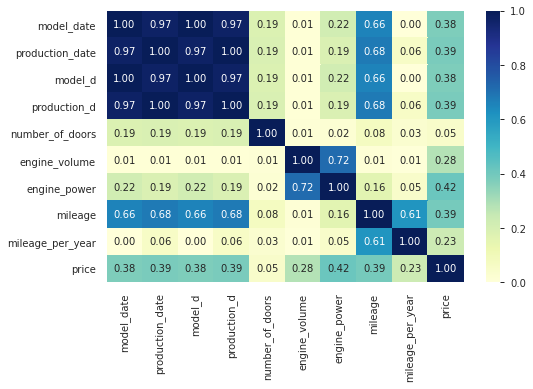

In [169]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(data[num_cols + ['price']].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".2f", cmap="YlGnBu")

Признаки model_date, production_date, model_d, production_d полностью коррелируют друг  другом, поэтому оставим только один из них: production_d

In [170]:
data = data.drop(['model_date', 'production_date', 'model_d'], 1)

In [171]:
num_cols.remove('model_date')
num_cols.remove('production_date')
num_cols.remove('model_d')

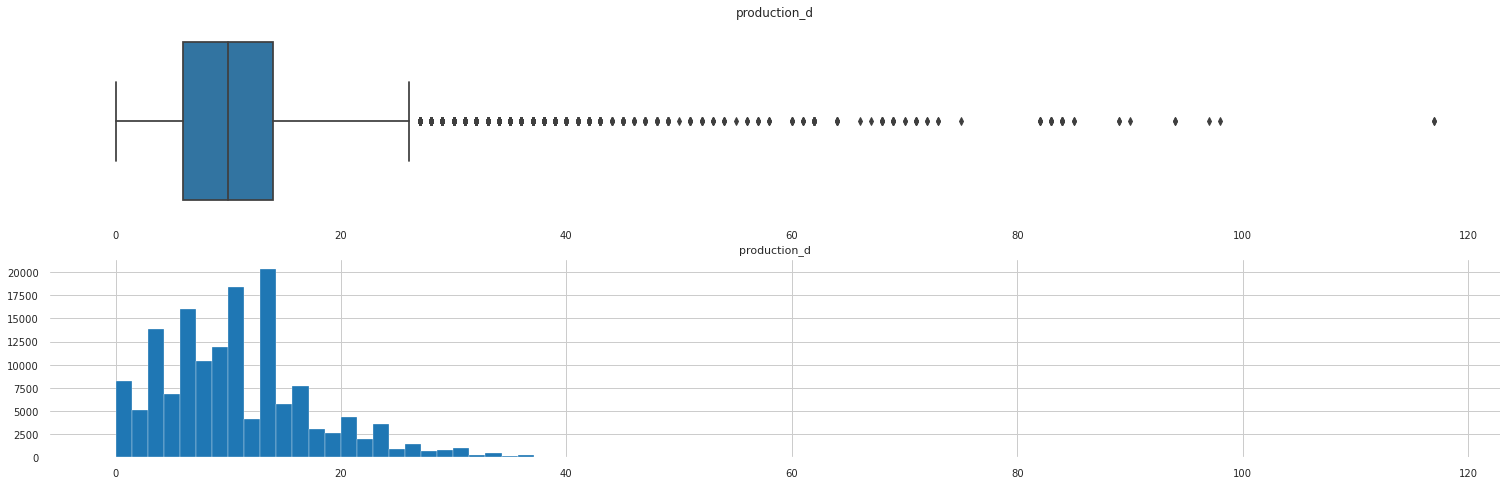

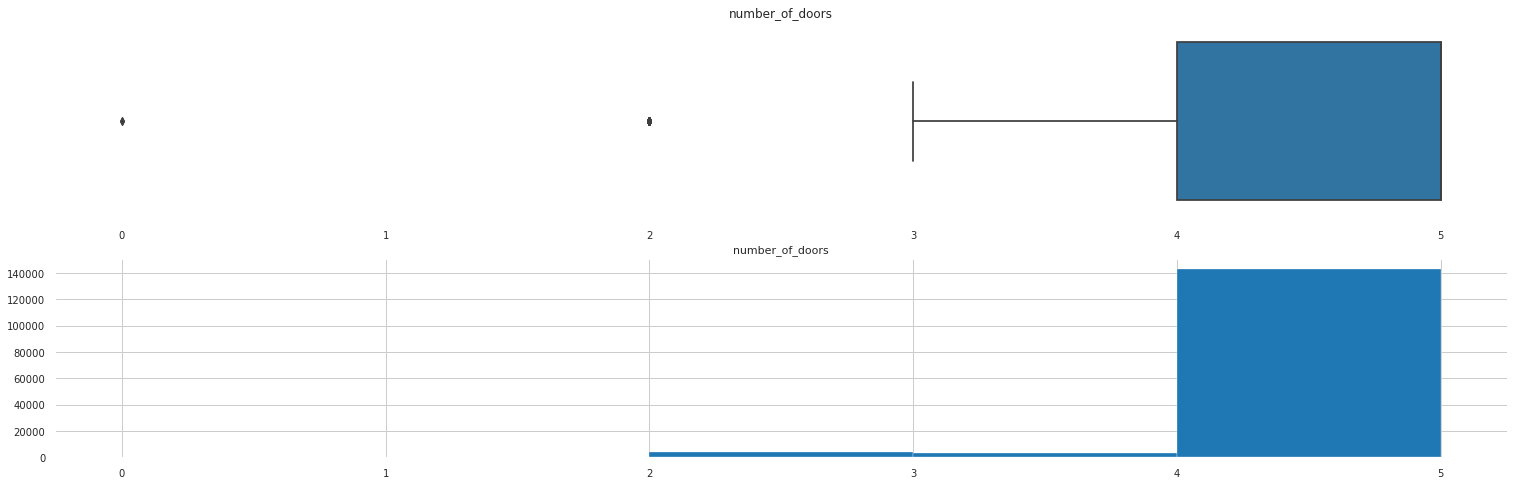

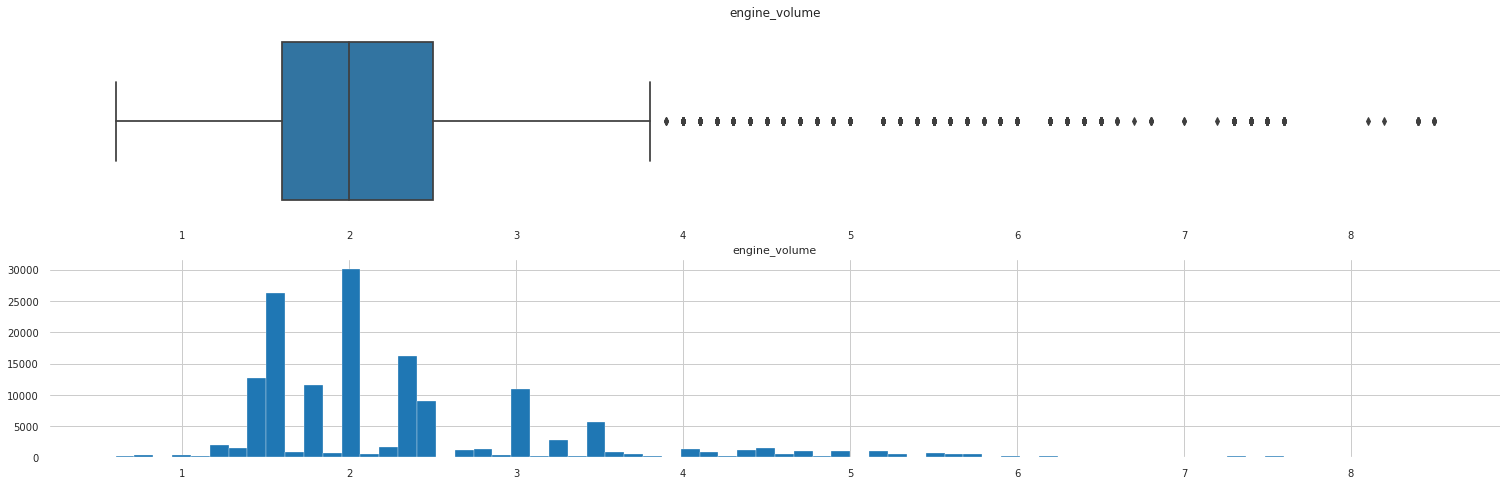

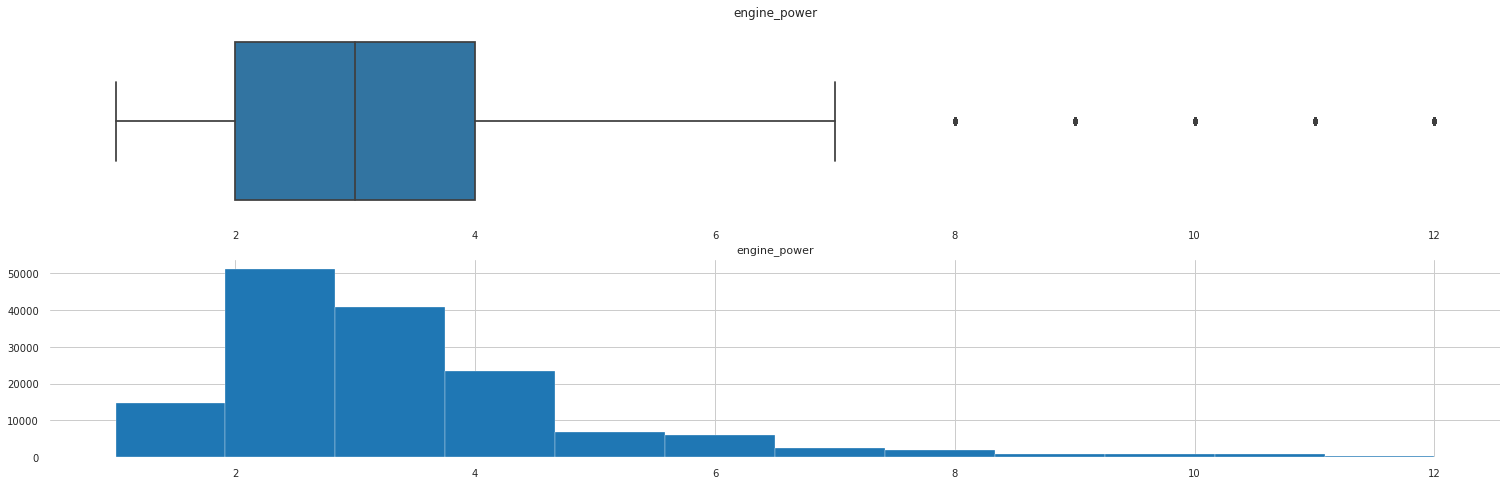

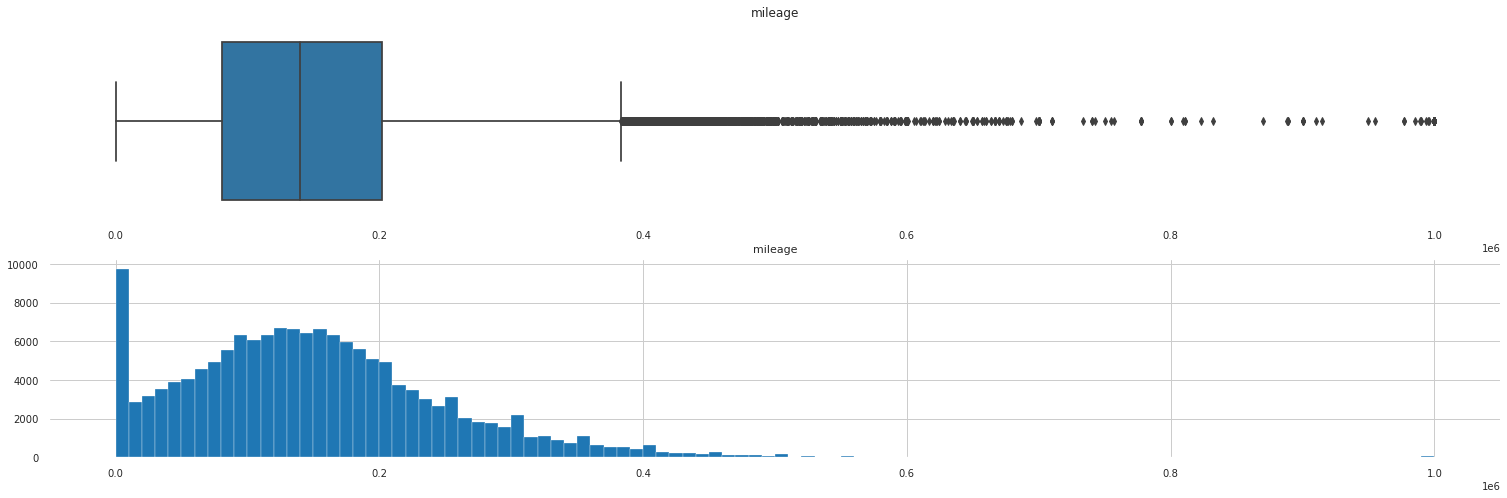

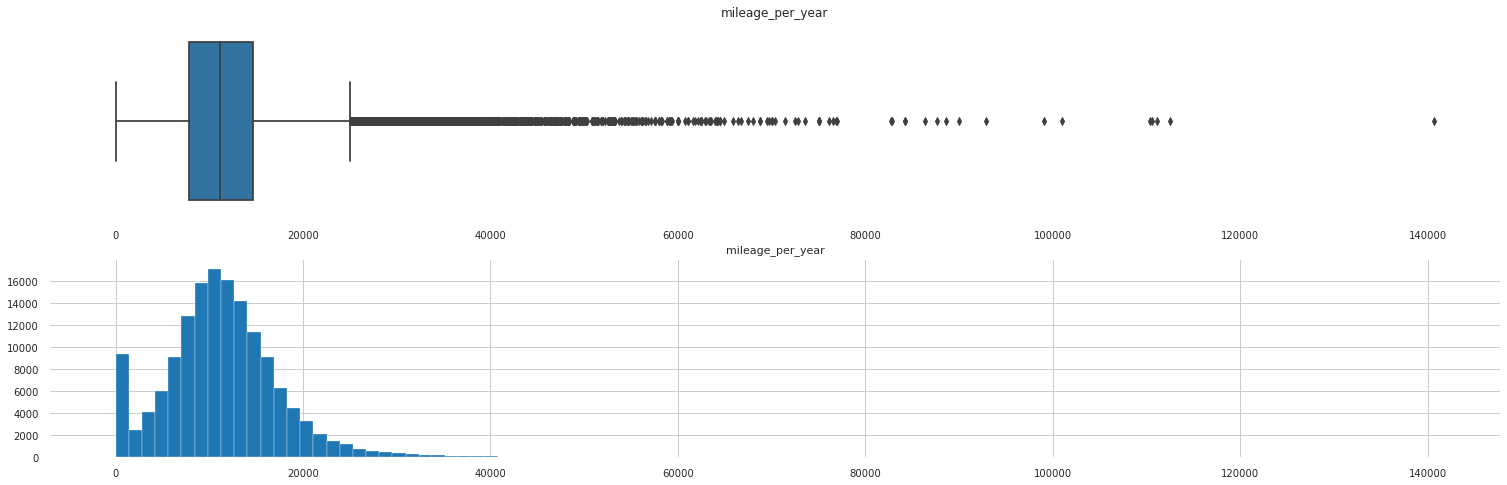

In [172]:
for col in num_cols:
    visualizing_number(data, col)

Text(0.5, 1.0, 'Значимость чиловых переменных для price')

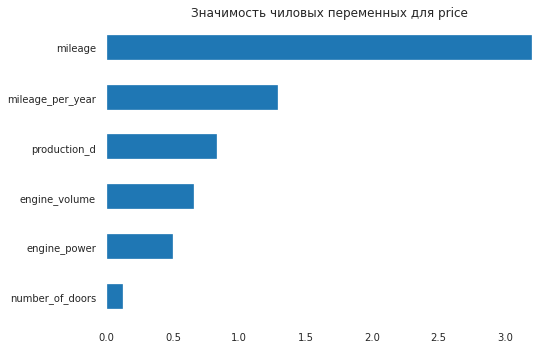

In [173]:
# #определяем значимость наших переменных:
imp_cat = Series(mutual_info_classif(data[data['price'] >0][num_cols], 
                                     data[data['price'] >0]['price'],
                                     discrete_features = True), index = num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость чиловых переменных для price')

**imp_cat - это весы для признаков, будем использовать эти данные при обучении**

## 2. Анализ категориальных и бинарных переменных

In [174]:
data[ready_cat_cols + cat_cols + bin_cols]

,color,owners_qty,licence,model_of_car,body_type,brand,fuel_type,transmis,vehicle_configuration,type_of_drive,steering_wheel
0,2,3.0,1.0,octavia,лифтбек,SKODA,petrol,AMT,robot,front,left
1,1,1.0,1.0,octavia,лифтбек,SKODA,petrol,MT,mechanical,front,left
2,2,1.0,1.0,superb,лифтбек,SKODA,petrol,AMT,robot,front,left
3,3,1.0,1.0,octavia,лифтбек,SKODA,petrol,AT,automatic,front,left
4,1,1.0,1.0,octavia,лифтбек,SKODA,petrol,AT,automatic,front,left
...,...,...,...,...,...,...,...,...,...,...,...
158299,1,3.0,1.0,rodius,минивэн,SSANG_YONG,diesel,AT,automatic,full,left
158300,2,3.0,1.0,rodius,минивэн,SSANG_YONG,diesel,AT,automatic,full,left
158301,1,1.0,1.0,stavic,минивэн,SSANG_YONG,diesel,AT,automatic,full,left
158302,2,3.0,1.0,stavic,минивэн,SSANG_YONG,diesel,AT,automatic,full,left


Заметим, что vehicle_configuration и transmis означают одно и то же. Удалим vehicle_configuration

In [175]:
data = data.drop(['vehicle_configuration'], 1)

In [176]:
cat_cols.remove('vehicle_configuration')

In [177]:
for col in cat_cols:
    print(col)
    print(data[col].value_counts())
    print()

model_of_car
octavia       4363
5er           3239
passat        2629
polo          2623
e_klasse      2587
              ... 
kei              1
mx_6             1
corolla_ii       1
ray              1
roomy            1
Name: model_of_car, Length: 1155, dtype: int64

body_type
внедорожник      54440
седан            53748
хэтчбек          15478
лифтбек           8271
универсал         5930
минивэн           4010
компактвэн        2924
купе              2922
пикап             1149
купе-хардтоп       478
кабриолет          352
родстер            334
фургон             322
микровэн            48
седан-хардтоп       36
лимузин             15
тарга               11
фастбек              4
Name: body_type, dtype: int64

brand
MERCEDES      14318
BMW           14254
VOLKSWAGEN    14253
NISSAN        12782
TOYOTA        11548
AUDI          10462
MITSUBISHI     9285
SKODA          8957
HYUNDAI        5356
VOLVO          5334
KIA            5305
FORD           4763
HONDA          4305
CHEVROLET

Разделим cat_cols:
- Если категорий мало, то будем обрабатывать их с помощью Dumming,
- Если категорий много, то - LabelEncoder 

К категориям на LabelEncoder добавим bin_cols - бинарные признаки

In [178]:
data[bin_cols]

,steering_wheel
0,left
1,left
2,left
3,left
4,left
...,...
158299,left
158300,left
158301,left
158302,left


In [179]:
# cat_cols
cat_oh_cols = ['fuel_type', 'transmis', 'type_of_drive']
cat_le_cols = ['model_of_car', 'body_type', 'brand', 'steering_wheel']

In [180]:
# Преобразуем все значения категориальных признаков в числа:
data = pd.get_dummies(data, columns=cat_oh_cols, dummy_na=False)

In [181]:
# Преобразуем все значения категориальных признаков в числа:

label_encoder = LabelEncoder()
for i in cat_le_cols:
    data[i] = label_encoder.fit_transform(data[i])
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150472 entries, 0 to 158303
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            150472 non-null  int64  
 1   brand                150472 non-null  int64  
 2   model_of_car         150472 non-null  int64  
 3   color                150472 non-null  int64  
 4   engine_volume        150472 non-null  float64
 5   engine_power         150472 non-null  int64  
 6   mileage              150472 non-null  int64  
 7   production_d         150472 non-null  int64  
 8   number_of_doors      150472 non-null  float64
 9   sell_id              150472 non-null  int64  
 10  owners_qty           150472 non-null  float64
 11  licence              150472 non-null  float64
 12  mileage_per_year     150472 non-null  float64
 13  steering_wheel       150472 non-null  int64  
 14  price                150472 non-null  float64
 15  sample           

**Оценим влияние категориальных признаков на целевую переменную**

In [182]:
cat_new_cols = data.columns
# len(cat_cols)
cat_new_cols = [x for x in cat_new_cols if x not in (num_cols + ['sell_id','price','sample'])]
data[cat_new_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150472 entries, 0 to 158303
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            150472 non-null  int64  
 1   brand                150472 non-null  int64  
 2   model_of_car         150472 non-null  int64  
 3   color                150472 non-null  int64  
 4   owners_qty           150472 non-null  float64
 5   licence              150472 non-null  float64
 6   steering_wheel       150472 non-null  int64  
 7   fuel_type_diesel     150472 non-null  uint8  
 8   fuel_type_electro    150472 non-null  uint8  
 9   fuel_type_gas        150472 non-null  uint8  
 10  fuel_type_hybrid     150472 non-null  uint8  
 11  fuel_type_petrol     150472 non-null  uint8  
 12  transmis_AMT         150472 non-null  uint8  
 13  transmis_AT          150472 non-null  uint8  
 14  transmis_CVT         150472 non-null  uint8  
 15  transmis_MT      

In [183]:
imp_num = imp_cat.copy()

Text(0.5, 1.0, 'Влияние категориальных признаков на price')

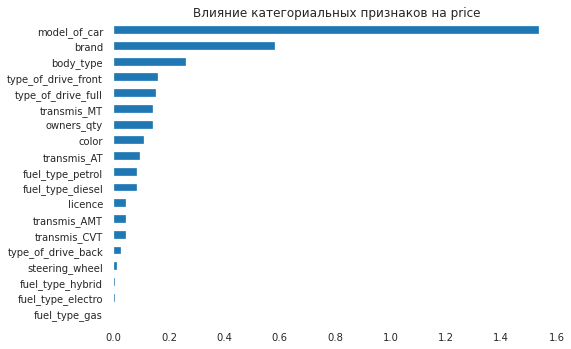

In [184]:
imp_cat = Series(mutual_info_classif(data[data['price'].isna() == False][cat_new_cols], 
                                     data[data['price'].isna() == False]['price'],
                                     discrete_features = True), index = cat_new_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Влияние категориальных признаков на price')

Объединим веса в один сериес. Нужно перевести его в list, но чтобы значения признаков стояли в том же порядке, что и в data

In [185]:
imp_weights = pd.concat([imp_num, imp_cat]).drop_duplicates()
cols = data.columns
weights = [imp_weights[col] for col in cols if col not in ['sell_id', 'price', 'sample']]
weights


[0.2598420544532554,
 0.584722254783069,
 1.5358601409722747,
 0.10906383910677706,
 0.6611426465135456,
 0.5000900381074692,
 3.2018591841560973,
 0.8346842197439535,
 0.12230722576410077,
 0.1426790904241566,
 0.04562003826217516,
 1.2889327564275799,
 0.013708160169295238,
 0.08440383887192603,
 0.0038307130403143095,
 0.00031540682766595656,
 0.005842868447791583,
 0.08596834037119944,
 0.04413467360471849,
 0.09524821947400779,
 0.04367541814456523,
 0.14292494007165915,
 0.02595454467200306,
 0.1600269221920217,
 0.1546096066877986]

# Улучшение числовых признаков
Проведем нормализацию и логарифмирование

In [186]:
# # data = data20.copy()
# dn = data.copy()

К числовым признакам добавим еще и те категориальные признаки, которые мы обработали с помощью LabelEncoding, так как получили в них большой разброс чисел

In [187]:
# dd = dn.drop(['sample','sell_id','price'],1).copy()
# dd = pd.DataFrame(StandardScaler().fit_transform(dd), columns = dd.columns)
# dn[dd.columns] = dd
# dn

In [188]:
# # 'production_d', 'engine_power', 'mileage', 'mileage_per_year'
# dn[['production_d', 'engine_power', 'mileage', 'mileage_per_year']] = np.log(dn[['production_d', 'engine_power', 'mileage', 'mileage_per_year']] + 1)

In [189]:
# for col in num_cols:
#     visualizing_number(data20, col)

In [190]:
# for col in num_cols:
#     visualizing_number(dn, col)

In [191]:
# data20 = data.copy()
# data = dn.copy()

# Разделение переменных

In [192]:
X = data.query('sample == 1').drop(['sample', 'price', 'sell_id'], axis=1)
X_sub = data.query('sample == 0').drop(['sample', 'price'], axis=1)
y = data.query('sample == 1')['price'].values
X_sub

,body_type,brand,model_of_car,color,engine_volume,engine_power,mileage,production_d,number_of_doors,sell_id,...,fuel_type_gas,fuel_type_hybrid,fuel_type_petrol,transmis_AMT,transmis_AT,transmis_CVT,transmis_MT,type_of_drive_back,type_of_drive_front,type_of_drive_full
0,6,29,718,2,1.2,2,74000,7,5.0,1100575026,...,0,0,1,1,0,0,0,0,1,0
1,6,29,718,1,1.6,2,60563,4,5.0,1100549428,...,0,0,1,0,0,0,1,0,1,0
2,6,29,973,2,1.8,3,88000,7,5.0,1100658222,...,0,0,1,1,0,0,0,0,1,0
3,6,29,718,3,1.6,2,95000,7,5.0,1100937408,...,0,0,1,0,1,0,0,0,1,0
4,6,29,718,1,1.8,3,58536,9,5.0,1101037972,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,11,1,50,3,1.6,2,115000,7,4.0,1101369263,...,0,0,1,0,1,0,0,1,0,0
34682,11,1,66,1,2.0,3,98000,3,4.0,1101369581,...,0,0,0,0,1,0,0,0,0,1
34683,11,1,66,2,2.5,3,360000,24,4.0,1101364889,...,0,0,1,0,1,0,0,1,0,0
34684,0,1,1103,3,2.0,3,90500,8,5.0,1101362518,...,0,0,0,0,1,0,0,0,0,1


In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_train

,body_type,brand,model_of_car,color,engine_volume,engine_power,mileage,production_d,number_of_doors,owners_qty,...,fuel_type_gas,fuel_type_hybrid,fuel_type_petrol,transmis_AMT,transmis_AT,transmis_CVT,transmis_MT,type_of_drive_back,type_of_drive_front,type_of_drive_full
36326,6,29,718,1,1.4,3,34539,3,5.0,1.0,...,0,0,1,1,0,0,0,0,1,0
105807,0,17,937,2,2.4,3,117000,8,5.0,3.0,...,0,0,1,0,1,0,0,0,0,1
136940,17,33,659,3,1.8,2,120000,19,5.0,1.0,...,0,0,1,0,1,0,0,0,1,0
51755,0,24,802,3,1.2,2,18217,2,5.0,1.0,...,0,0,1,0,0,1,0,0,1,0
94132,11,13,103,2,2.3,2,148000,13,4.0,2.0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115338,11,24,119,1,1.6,2,72000,4,4.0,1.0,...,0,0,1,0,0,0,1,0,1,0
151642,11,21,363,3,3.0,4,160000,12,4.0,2.0,...,0,0,1,0,1,0,0,1,0,0
144639,0,34,1005,1,3.2,4,235992,17,5.0,3.0,...,0,0,1,0,1,0,0,0,0,1
35546,6,29,827,4,1.6,1,290000,4,5.0,2.0,...,0,0,1,0,0,0,1,0,1,0


In [194]:
# def standart():



# # Model 1 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [195]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

stsc = StandardScaler()
X_train = stsc.fit_transform(X_train)
X_test = stsc.transform(X_test)

# Добавим веса
X_train = X_train * weights
X_test = X_test * weights


In [196]:
# model.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# # model.save_model('catboost_single_model_baseline.model')

# # оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
# # Без стандартизации Точность модели по метрике MAPE: 15.61%

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [197]:
np.log(y_train)

array([14.28488899, 13.92883924, 12.50246666, ..., 13.38472764,
       12.95984445, 13.52782849])

In [198]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# model.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# # model.save_model('catboost_single_model_2_baseline.model')

In [199]:
# predict_test = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))

In [200]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
# # без стандартизации и логорифмирования
# # Точность модели по метрике MAPE: 13.74%

# # Model 2 : LinearRegression

In [201]:
# lin_reg = LinearRegression().fit(X_train, y_train)
# y_pred = lin_reg.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# # Точность модели по метрике MAPE: 117.26%

# # Model 3: GradientBoosting

In [202]:
# # max_depth должно примерно соответствовать количеству признаков или быть больше.
# gb = GradientBoostingRegressor(min_samples_split=2,
#                                learning_rate=0.03,
#                                max_depth=30,
#                                n_estimators=1000)
# gb.fit(X_train,y_train)
# # Сначала попробуем без логорифмирования таргета
# y_pred = gb.predict(X_test)
# print(f"Точность модели по метрике MAPE_без лого: {(mape(y_test, y_pred))*100:0.2f}%")

# # 
# # Точность модели по метрике MAPE: 14.96%
# # 

# # без стандартизации и логорифмирования 15.65%

In [203]:
# #Тоже самое с логорифмом таргета
# gb.fit(X_train,np.log(y_train))
# y_pred = gb.predict(X_test)
# print(f"Точность модели по метрике MAPE c лого: {(mape(y_test, y_pred))*100:0.2f}%")
# # Точность модели по метрике MAPE c лого: 100.00%

# # Model 4: Forest

In [204]:
# rf = RandomForestRegressor(n_estimators=1000,
#                            n_jobs=-1,
#                            max_depth=30,
#                            max_features='log2',
#                            random_state=RANDOM_SEED,
#                            oob_score=True)
# rf.fit(X_train,y_train)



In [205]:
# # Сначала попробуем без логорифмирования таргета
# y_pred = rf.predict(X_test)
# print(f"Точность модели по метрике MAPE_без лого: {(mape(y_test, y_pred))*100:0.2f}%")

# # Точность модели по метрике MAPE_без лого: 18.15%, max_depth=50, || 100
# # Точность модели по метрике MAPE_без лого: 18.10%, max_depth=30

# # Model 5: Xgboosting

In [206]:
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")


#Точность модели по метрике MAPE: 14.15%,  max_depth=8
#Точность модели по метрике MAPE: 13.89%,  max_depth=12
#Точность модели по метрике MAPE: 14.07%,  max_depth=35
#Точность модели по метрике MAPE: 14.02%,  max_depth=20

Точность модели по метрике MAPE: 13.89%


# # Model 6: StackingRegressor

Выбирем для стека самые лучшие модели,  которые мы получили: Xgboosting, CatBoosting. Для обработки результатов возьмем линейную регрессию.
До этого пробовали брать за последнюю модель CatBoosting, но результаты оказались хуже.

Брать много сложных моделей не будем, так как даже при 2-3 моделях выполнение обучения идет более 30 минут.

In [207]:
estimators = [('xb',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)),
              ('xb2',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=500)),
              ('cb', CatBoostRegressor(iterations = 2000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         ))
            ]



In [208]:
st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

# Точность модели по метрике MAPE: 14.01%: xb1_12_1000, xb2_12_500,-> cb
# Точность модели по метрике MAPE: 13.80%: xb1_12_1000, xb2_12_500, cb -> LR

Точность модели по метрике MAPE: 13.80%


# Выбор модели


Во время исследования все модели запускались много раз. У нас были следующие параметры для проверки:
- Подключать или нет датасет 2020 года
- учитывать или нет инфляцию для датасета 2021 года
- учитывать или нет авто старше 2020 года в трейне,
- логорифмировать или нет числовые признаки,
- Выбор обработки категориальных данных: Dumming, LabelEncoding
- Проводить или нет стандартизацию данных перед обучением
- Учитывать вес каждого признака или нет.

По логике все эти процедуры должны улучшать обучение, однако, например 

- учет или не учет авто старше 2020 года не изменяет результат. Просто таких авто мало в процентах.

- Подключение датасета 2020 года повлияло очень сильно. Метрика на XBoost улучшилась в submission с 20% до 13%. Однако на трейне получили 13% в обоих случаях. Это конечно же влияет то, что цены за год сильно изменились.

- Логорифмирование числовых данных немного ухудшает модель. Убрали эту процедуру.

- Выбор того, как распределить категориальные переменные для обработки указан выше. Это оказался оптимальный вариант, который дал не так много новых столбцов.


<table class="table">
  <thead>
    <tr>
      <th scope="col">#</th>
      <th scope="col">Model</th>
      <th scope="col">отброшены старше 1980</th>
      <th scope="col">Проведена стандартизация и веса</th>
      <th scope="col">max_depth</th>
      <th scope="col">MAPE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">1</th>
      <td>CatBoost</td>
      <td>no</td>
      <td>yes</td>
      <td>-</td>
      <td>17.15%</td>
    </tr>
    <tr>
      <th scope="row">1</th>
      <td>CatBoost (log res)</td>
      <td>no</td>
      <td>yes</td>
      <td>-</td>
      <td>14.24%</td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>LinearRegression</td>
      <td>no</td>
      <td>yes</td>
      <td>-</td>
      <td>117.26%</td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td>GradientBoosting</td>
      <td>no</td>
      <td>yes</td>
      <td>30</td>
      <td>14.96%</td>
    </tr>
    <tr>
      <th scope="row">4</th>
      <td>RandomForest</td>
      <td>no</td>
      <td>yes</td>
      <td>30</td>
      <td>18.10%</td>
    </tr>
    <tr>
      <th scope="row">4</th>
      <td>RandomForest</td>
      <td>no</td>
      <td>yes</td>
      <td>50</td>
      <td>18.15%</td>
    </tr>
    <tr>
      <th scope="row">5</th>
      <td>Xgboosting</td>
      <td>no</td>
      <td>yes</td>
      <td>12</td>
      <td>13.89%</td>
    </tr>
      <tr>
      <th scope="row">5</th>
      <td>Xgboosting</td>
      <td>no</td>
      <td>yes</td>
      <td>20</td>
      <td>14.02%</td>
    </tr>
  <tr>
      <th scope="row">5</th>
      <td>Xgboosting</td>
      <td>no</td>
      <td>yes</td>
      <td>35</td>
      <td>14.07%</td>
    </tr>
    <tr>
      <th scope="row">6</th>
      <td>Stacking</td>
      <td>no</td>
      <td>yes</td>
      <td>Stack models: Xb,Xb, Cb. Finish: LR</td>
      <td>13.80</td>
    </tr>
  </tbody>
</table>

# Submission

In [209]:
X_sub_st = stsc.transform(X_sub.drop('sell_id',1))
X_sub_st = X_sub_st * weights
# X_sub_st['sell_id']


In [210]:
# xb.fit(X_train, np.log(y_train+1))
# X_train
pred = np.exp(st_ensemble.predict(X_sub_st))

In [211]:
predict_submission = np.round(pred,-3).astype('int')


In [212]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,688000
1,1100549428,984000
2,1100658222,1069000
3,1100937408,769000
4,1101037972,820000
5,1100912634,847000
6,1101228730,724000
7,1100165896,453000
8,1100768262,2030000
9,1101218501,966000


In [213]:
!ls '../input'

cars-df-v2  parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


# Выводы:

Лучший результат на валидации показала модель Xgboosting: 13.69623%, лучше чем StackingRegression: 13.77556%
Как мы уже не раз убеждались, сильнее всего на результат влияют сами данные. Спарсить удалось только 34 тыс. объявлений 2021 года, а в тесте данные 2020 года. Цены на авто сильно изменились, причем не равномерно по моделям. Сделали учет инфляции в среднем по брендам и добавили датасет объявлений за 2020 год.

В Exploratory data analysis провели следующие преобразования:
- выделили модели из car_url,
- выделили группы цветов по-популярности,
- рассчитали пробег в год,
- рассчитали возраст авто,
- обработали категориальные переменные.

Что можно было еще сделать:
- Можно было обработать поля комплектации equipmentGroups, обычно от этого цена сильно зависит.
